# Every Function You Can (Should) Use in Pandas to Manipulate Time Series

https://www.kaggle.com/code/bextuychiev/every-pandas-function-to-manipulate-time-series/notebook

## Setup

In [89]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

In [90]:
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["legend.fontsize"] = "small"

pd.set_option("precision", 2)
warnings.filterwarnings("ignore")

OptionError: 'Pattern matched multiple keys'

## Introduction to this project on Time Series Forecasting

Recently, the Optiver Realized Volatility Prediction competition has been launched on Kaggle. As the name suggests, it is a time series forecasting challenge.

I wanted to participate, but it turns out my knowledge in time series couldn't even begin to suffice to participate in a competition of such a magnitude. So, I accepted this as the 'kick in the pants' I needed to start paying serious attention to this large sphere of ML.

As the first step, I wanted to learn and teach every single Pandas function you can use to manipulate time-series data. These functions are the basic requirements for dealing with any time series data you encounter in the wild.

I have got rather cool and interesting articles/notebooks planned on this topic, and today, you will be reading the first taste of what is to come. Enjoy!

## Table of Contents 

1. Basic date and time functions
1.1 Importing time series data
1.2 Pandas TimeStamp
1.3 Sequence of dates (timestamps)
1.4 Slicing

2. Missing data imputation/interpolation in time series
2.1 Mean, median and mode imputation
2.2 Forward and backward filling
2.3 Using pd.interpolate
2.4 Model based imputation with KNN

3. Basic time series calculations and metrics
3.1 Shifts and lags
3.2 Percentage changes

4. Resampling - upsample and downsample
4.1 Changing the frequency with asfreq
4.2 Downsampling with resample and aggregating
4.3 Upsampling with resample and interpolating
4.4 Plotting the resampled data

5. Comparing the growth of multiple time series

6. Window functions

6.1 Rolling window functions
6.2 Expanding window functions

7. Summary

## 1. Basic date and time functions in Pandas
### 1.1 Importing time series data 

When using the pd.read_csv function to import time series, there are 2 arguments you should always use - parse_dates and index_col:

In [ ]:
# Import Apple/Google stock prices
aapl_googl = pd.read_csv(
    "https://raw.githubusercontent.com/naikshubham/Forecasting-using-Python/master/Manipulating-Time-Series-Data/data/msft_aapl.csv",
    parse_dates=["date"],
    index_col="date",
).dropna()

In [ ]:
aapl_googl.head()

,AAPL,MSFT
date,,
2007-01-03,11.97,29.86
2007-01-04,12.24,29.81
2007-01-05,12.15,29.64
2007-01-08,12.21,29.93
2007-01-09,13.22,29.96


In [ ]:
# Import S&P500 stock prices
sp500 = pd.read_csv(
    "https://raw.githubusercontent.com/naikshubham/Forecasting-using-Python/master/Manipulating-Time-Series-Data/data/djia.csv",
    parse_dates=["date"],
    index_col="date",
)

In [ ]:
sp500.head()

,djia
date,
2007-06-29,13408.62
2007-07-02,13535.43
2007-07-03,13577.30
2007-07-04,NaN
2007-07-05,13565.84


parse_dates converts date-like strings to DateTime objects and index_col sets the passed column as the index. This operation is the basis for all time-series manipulation you will do with Pandas.

When you don't know which column contains dates upon importing, you can perform the date conversion using pd.to_datetime function afterward:

In [ ]:
# Import the data with unknown date column
sp500 = pd.read_csv("https://raw.githubusercontent.com/naikshubham/Forecasting-using-Python/master/Manipulating-Time-Series-Data/data/djia.csv")

# Inspect the dtypes
sp500.dtypes

date     object
djia    float64
dtype: object

In [ ]:
sp500.head()

,date,djia
0,2007-06-29,13408.62
1,2007-07-02,13535.43
2,2007-07-03,13577.30
3,2007-07-04,NaN
4,2007-07-05,13565.84


It is in the format "%Y-%m-%d" (full list of datetime format strings can be found here). Pass this to pd.to_datetime:

In [ ]:
sp500["date"] = pd.to_datetime(sp500["date"], format="%Y-%m-%d", errors="coerce")

# Check if the conversion is successful
assert sp500["date"].dtype == "datetime64[ns]"

Passing a format string to pd.to_datetime significantly speeds up the conversion for large datasets. Set errors to "coerce" to mark invalid dates as NaT (not a date, i.e. - missing).

After conversion, set the DateTime column as index (a strict requirement for best time series analysis):

In [ ]:
sp500.set_index("date", inplace=True)

## 1.2 Pandas TimeStamp

The basic date data structure in Pandas is a timestamp:

In [ ]:
stamp = pd.Timestamp("2020/12/26")  # You can pass any date-like string
stamp

Timestamp('2020-12-26 00:00:00')

You can make even more granular timestamps using the right format or, better yet, using the datetime module:

In [ ]:
from datetime import datetime

stamp = pd.Timestamp(
    datetime(year=2021, month=10, day=5, hour=13, minute=59, second=59)
)
stamp

Timestamp('2021-10-05 13:59:59')

A full timestamp has useful attributes such as these:

In [ ]:
attributes = [
    ".year",
    ".month",
    ".quarter",
    ".day",
    ".hour",
    ".minute",
    ".second",
    ".weekday()",
    ".dayofweek",
    ".weekofyear",
    ".dayofyear",
]

pd.DataFrame(
    {
        "Attribute": attributes,
        "'2021-10-05 13:59:59'": [
            eval(f"stamp{attribute}") for attribute in attributes
        ],
    }
)

,Attribute,'2021-10-05 13:59:59'
0,.year,2021
1,.month,10
2,.quarter,4
3,.day,5
4,.hour,13
5,.minute,59
6,.second,59
7,.weekday(),1
8,.dayofweek,1
9,.weekofyear,40


### 1.3 Sequence of dates (timestamps) 

A DateTime column/index in pandas is represented as a series of TimeStamp objects.

pd.date_range returns a special DateTimeIndex object that is a collection of TimeStamps with a custom frequency over a given range:

In [ ]:
index = pd.date_range(start="2010-10-10", end="2020-10-10", freq="M")
index

DatetimeIndex(['2010-10-31', '2010-11-30', '2010-12-31', '2011-01-31',
               '2011-02-28', '2011-03-31', '2011-04-30', '2011-05-31',
               '2011-06-30', '2011-07-31',
               ...
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30'],
              dtype='datetime64[ns]', length=120, freq='M')

After specifying the date range (from October 10, 2010, to the same date in 2020), we are telling pandas to generate TimeStamps on a monthly-basis with freq='M':

In [ ]:
index[0]

Timestamp('2010-10-31 00:00:00', freq='M')

Another way to create date ranges is passing the start date and telling how many periods you want, and specifying the frequency:

In [ ]:
pd.date_range(start="2020-01-01", periods=5, freq="Y")

DatetimeIndex(['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31',
               '2024-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

Since we set the frequency to years, date_range with 5 periods returns 5 years/timestamp objects. The list of frequency aliases that can be passed to freq is large, so I will only mention the most important ones here:

In [ ]:
aliases = ["B", "D", "W", "M", "BM", "MS", "Q", "H", "A, Y"]
values = [
    "Business days",
    "Calendar days",
    "Weekly",
    "Month end frequency",
    "Business month end frequency",
    "Month start frequency",
    "Quarterly",
    "Hourly",
    "Year end",
]

pd.DataFrame({"Frequency Alias": aliases, "Definition": values})

,Frequency Alias,Definition
0,B,Business days
1,D,Calendar days
2,W,Weekly
3,M,Month end frequency
4,BM,Business month end frequency
5,MS,Month start frequency
6,Q,Quarterly
7,H,Hourly
8,"A, Y",Year end


It is also possible to pass custom frequencies such as "1h30min", "5D", "2W", etc. Again, check out this link for the full info.


### 1.4 Slicing 

Slicing time series data can be very intuitive if the index is a DateTimeIndex. You can use something called partial slicing:

In [ ]:
aapl_googl["2010":"2015"].sample(5)  # All rows within 2010 and 2015

,AAPL,MSFT
date,,
2011-04-27,50.02,26.38
2015-12-18,106.03,54.13
2010-11-24,44.97,25.37
2010-08-02,37.41,26.33
2011-06-23,47.32,24.63


In [ ]:
aapl_googl["2012-4":"2012-12"].sample(5)  # rows within April and December of 2012

,AAPL,MSFT
date,,
2012-05-09,81.31,30.76
2012-06-27,82.07,30.17
2012-04-24,80.04,31.92
2012-06-12,82.31,29.29
2012-09-04,96.42,30.38


You can even go down to hours, minutes, or seconds levels if the DateTime is granular enough.

Note that pandas slices dates in closed intervals. For example, using "2010": "2013" returns rows for all 4 years - it does not exclude the end of the period like integer slicing.

This date slicing logic applies to other operations like choosing a specific column after the slice:

In [ ]:
aapl_googl.loc["2012-10-10":"2012-12-10", "MSFT"].head()

date
2012-10-10    28.98
2012-10-11    28.95
2012-10-12    29.20
2012-10-15    29.51
2012-10-16    29.49
Name: MSFT, dtype: float64

## 2. Missing data imputation or interpolation

Missing data is ubiquitous no matter the type of the dataset. This section is all about imputing it in the context of time series.

You may also hear it called interpolation of missing data in time series lingo.

Besides the basic mean, median and mode imputation, some of the most common techniques include:

Forward filling
Backward filling
Intermediate imputations with pd.interpolate
We will also discuss model-based imputation such as KNN imputing. Moreover, we will explore visual methods of comparing the efficiency of the techniques and choose the one that best fits the underlying distribution.

### 2.1 Mean, median and mode imputation 


Let's start with the basics. We will randomly select data points in Apple/Google stock dataset and convert them to NaN:

In [ ]:
# Choose 200 random
random_indices = np.random.choice([_ for _ in range(len(aapl_googl))], size=200)

# Mark the indices as missing
clone = aapl_googl.copy(deep=True).drop("AAPL", axis=1)
clone.iloc[random_indices, 0] = np.nan

We will also create a function that plots the original distribution before and after an imputation(s) is performed:

In [ ]:
def compare_dists(original_dist, imputed_dists: dict):
    """
    Plot original_dist and imputed_dists on top of each other
    to see the difference in distributions.
    """
    fig, ax = plt.subplots(figsize=(12, 7), dpi=140)
    # Plot the original
    sns.kdeplot(
        original_dist, linewidth=5, ax=ax, color="black", label="Original dist."
    )
    for key, value in imputed_dists.items():
        sns.kdeplot(value, linewidth=3, label=key, ax=ax)

    plt.legend()
    plt.show();

We will start trying out techniques with SimpleImputer from Sklearn:

In [ ]:
from sklearn.impute import SimpleImputer

for method in ["mean", "median", "most_frequent"]:
    clone[method] = SimpleImputer(strategy=method).fit_transform(
        clone["MSFT"].values.reshape(-1, 1)
    )

C:\Users\Dell\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_base.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Let's plot the original GOOG distribution against the 3 imputed features we just created:

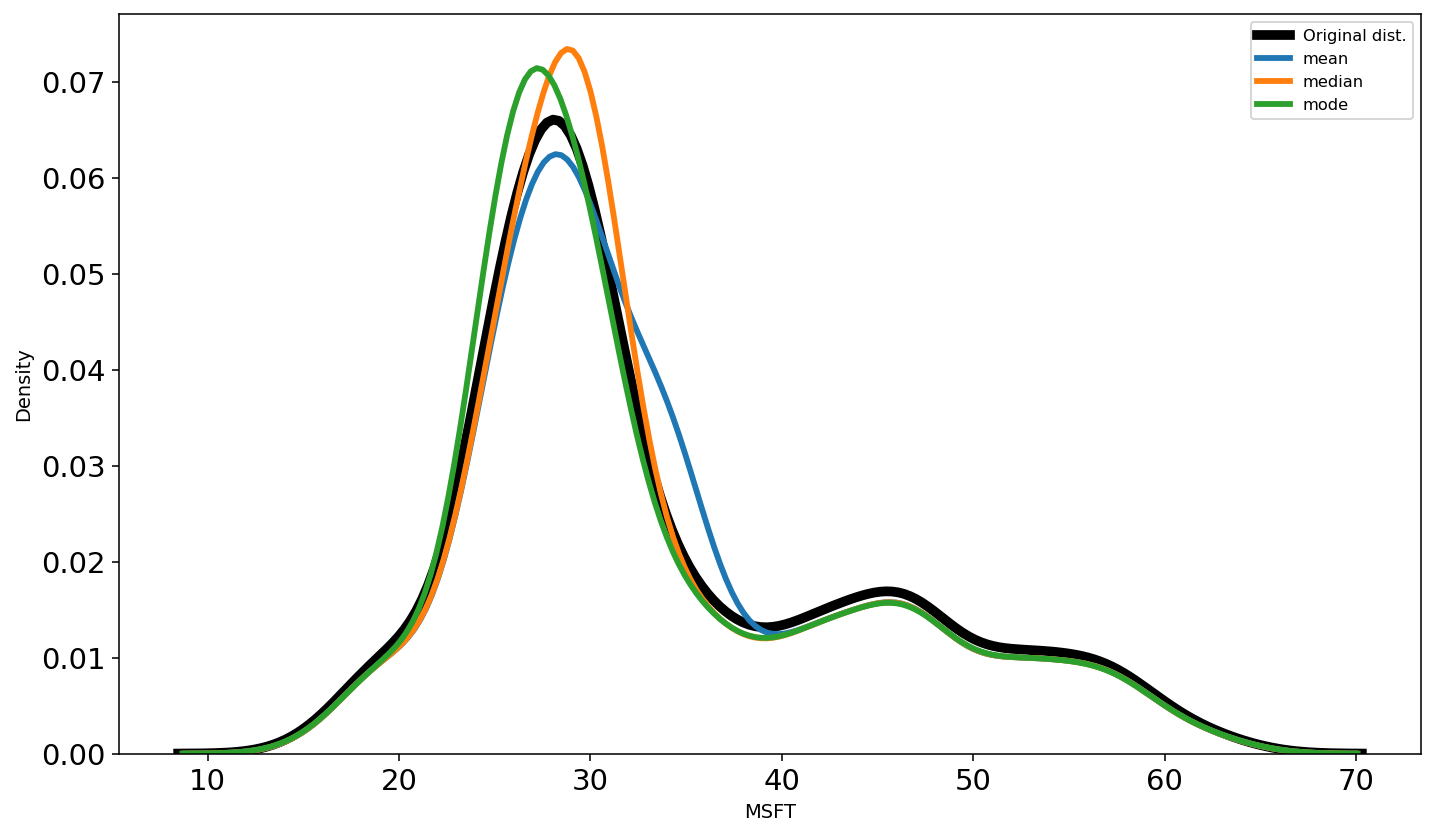

In [ ]:
compare_dists(
    clone["MSFT"],
    {"mean": clone["mean"], "median": clone["median"], "mode": clone["most_frequent"]},
)

It is hard to say which lines most closely resembles the black line, but I will go with the blue.

In [ ]:
clone.drop(["mean", "median", "most_frequent"], axis=1, inplace=True)

### 2.2 Forward and backward filling 


Consider this small distribution:

In [ ]:
sample = pd.Series([np.nan, 2, 3, np.nan, 4, np.nan, np.nan, 5, 12, np.nan]).to_frame(
    name="original"
)
sample

,original
0,NaN
1,2.0
2,3.0
3,NaN
4,4.0
5,NaN
6,NaN
7,5.0
8,12.0
9,NaN


We will use both forward and backward filling and assign them back to the DataFrame as separate columns:

In [ ]:
sample["ffill"] = sample["original"].ffill()
sample["bfill"] = sample["original"].bfill()

sample

,original,ffill,bfill
0,NaN,NaN,2.0
1,2.0,2.0,2.0
2,3.0,3.0,3.0
3,NaN,3.0,4.0
4,4.0,4.0,4.0
5,NaN,4.0,5.0
6,NaN,4.0,5.0
7,5.0,5.0,5.0
8,12.0,12.0,12.0
9,NaN,12.0,NaN


It should be fairly obvious how these methods work once you examine the above output.

Now, let's perform these methods on the Airquality in India dataset:

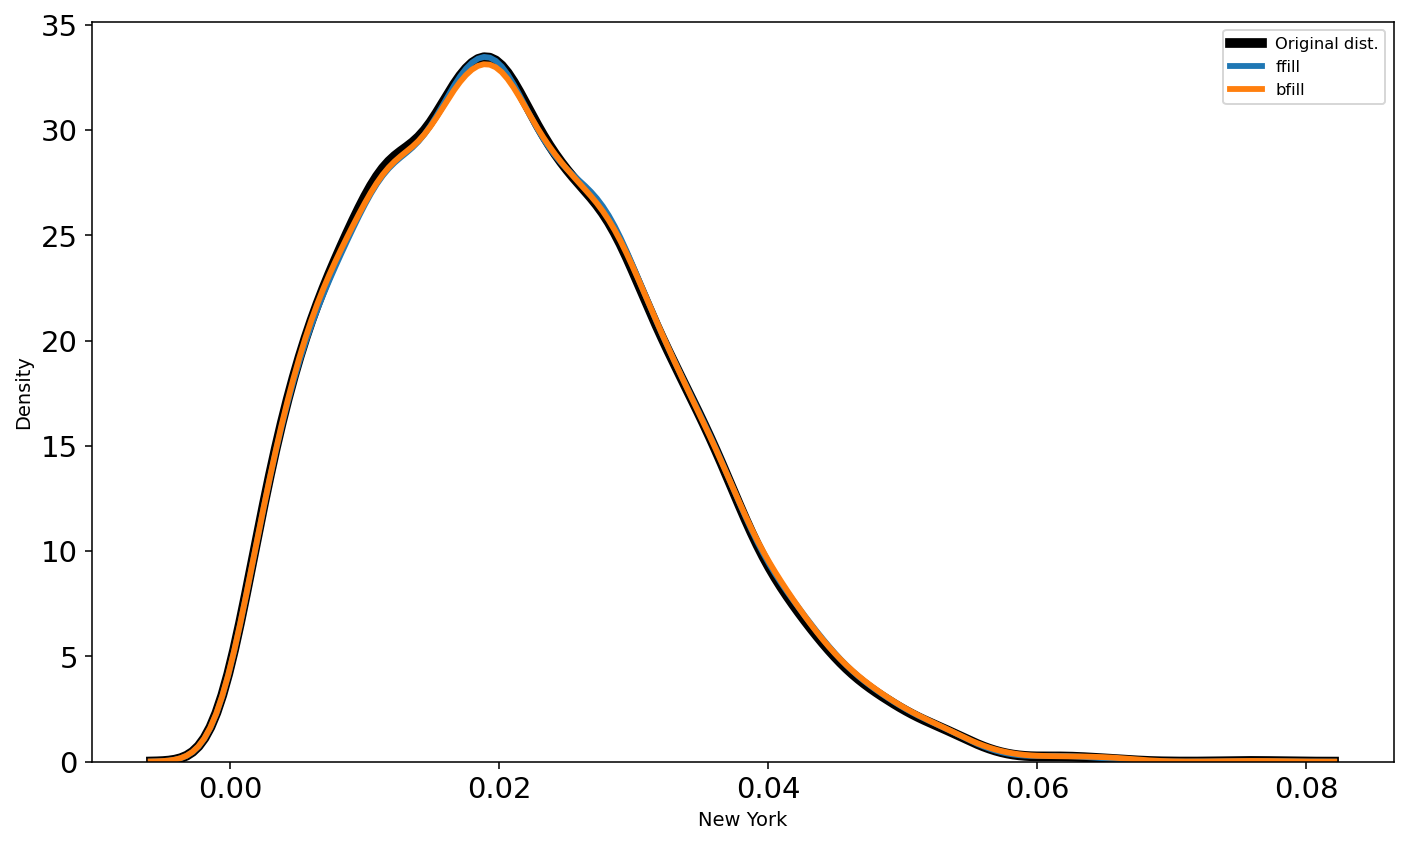

In [ ]:
air_q = pd.read_csv(
    "https://raw.githubusercontent.com/naikshubham/Forecasting-using-Python/master/Manipulating-Time-Series-Data/data/ozone_nyla.csv",
    usecols=["date", "New York"],
    parse_dates=["date"],
    index_col="date",
)

for method in ["ffill", "bfill"]:
    air_q[method] = eval(f"air_q['New York'].{method}()")

compare_dists(air_q["New York"], {"ffill": air_q["ffill"], "bfill": air_q["bfill"]})

Even though very basic, forward and backward filling actually works pretty well on climate and stocks data since the differences between nearby data points are small.


### 2.3 Using pd.interpolate ¶


Pandas provides a whole suite of other statistical imputation techniques in pd.interpolate function. Its method parameter accepts the name of the technique as a string.

The most popular ones are 'linear' and 'nearest,' but you can see the full list from the function's documentation. Here, we will only discuss those two.

Consider this small distribution:

In [ ]:
sample = pd.Series([1] + [np.nan] * 6 + [10]).to_frame(name="original")
sample

,original
0,1.0
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,10.0


Once again, we apply the methods and assign their results back:

In [ ]:
sample["linear"] = sample.original.interpolate(method="linear")
sample["nearest"] = sample.original.interpolate(method="nearest")

sample

,original,linear,nearest
0,1.0,1.000000,1.0
1,NaN,2.285714,1.0
2,NaN,3.571429,1.0
3,NaN,4.857143,1.0
4,NaN,6.142857,10.0
5,NaN,7.428571,10.0
6,NaN,8.714286,10.0
7,10.0,10.000000,10.0


Neat, huh? The linear method considers the distance between any two non-missing points as linearly spaced and finds a linear line that connects them (like np.linspace). 'Nearest' method should be understandable from its name and the above output.


### 2.4 Model based imputation with KNN 


The last method we will see is the K-Nearest-Neighbors algorithm. I won't detail how the algorithm works but only show how you can use it with Sklearn. If you want the details, I have a separate article here.

The most important parameter of KNN is k - the number of neighbors. We will apply the technique to Apple/Google data with several values of k and find the best one the same way as we did in the previous sections:

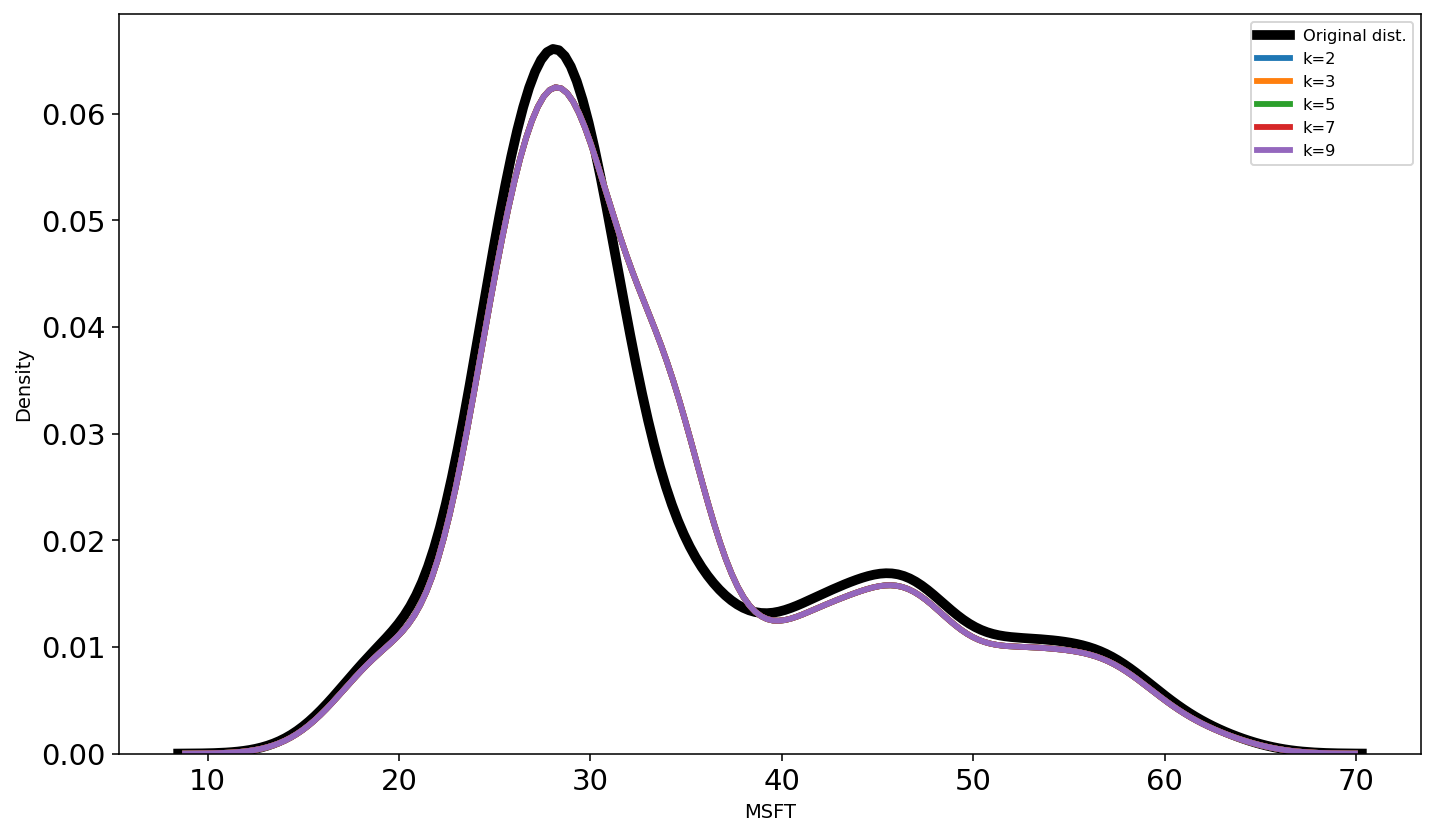

In [ ]:
from sklearn.impute import KNNImputer

n_neighbors = [2, 3, 5, 7, 9]

for k in n_neighbors:
    imp = KNNImputer(n_neighbors=k)
    clone[f"k={k}"] = imp.fit_transform(clone["MSFT"].values.reshape(-1, 1))

compare_dists(clone["MSFT"], {f"k={k}": clone[f"k={k}"] for k in n_neighbors})

## 3. Basic time series calculations 


Pandas offers basic functions to calculate the most common time series calculations. These are called shifts, lags, and something called a percentage change.

### 3.1 Shifts and lags 


A common operation in time series is to move all data points one or more periods backward or forward to compare past and future values. You can do these operations using shift function of pandas. Let's see how to move the data points 1 and 2 periods into the future:

In [ ]:
sp500 = pd.read_csv("https://raw.githubusercontent.com/naikshubham/Forecasting-using-Python/master/Manipulating-Time-Series-Data/data/djia.csv", parse_dates=["date"], index_col="date")

sp500.head()

,djia
date,
2007-06-29,13408.62
2007-07-02,13535.43
2007-07-03,13577.30
2007-07-04,NaN
2007-07-05,13565.84


In [ ]:
sp500["shifted_1"] = sp500["djia"].shift(periods=1)  # the default
sp500["shifted_2"] = sp500["djia"].shift(periods=2)

sp500.head(6)

,djia,shifted_1,shifted_2
date,,,
2007-06-29,13408.62,NaN,NaN
2007-07-02,13535.43,13408.62,NaN
2007-07-03,13577.30,13535.43,13408.62
2007-07-04,NaN,13577.30,13535.43
2007-07-05,13565.84,NaN,13577.30
2007-07-06,13611.68,13565.84,NaN


Shifting forward enables you to compare the current data point to those recorded one or more periods before.

You can also shift backward. This operation is also called "lagging":

In [ ]:
sp500.drop(["shifted_1", "shifted_2"], axis=1, inplace=True)

sp500["lagged_1"] = sp500["djia"].shift(periods=-1)
sp500["lagged_2"] = sp500["djia"].shift(periods=-2)

sp500.tail(6)

,djia,lagged_1,lagged_2
date,,,
2017-06-22,21397.29,21394.76,21409.55
2017-06-23,21394.76,21409.55,21310.66
2017-06-26,21409.55,21310.66,21454.61
2017-06-27,21310.66,21454.61,21287.03
2017-06-28,21454.61,21287.03,NaN
2017-06-29,21287.03,NaN,NaN


Shifting backward enables us to see the difference between the current data point and the one that comes one or more periods later.

A common operation after shifting or lagging is finding the difference and plotting it:

In [ ]:
sp500.drop("lagged_2", axis=1, inplace=True)

sp500["diff_lag"] = sp500["lagged_1"] - sp500["djia"]
sp500.head()

,djia,lagged_1,diff_lag
date,,,
2007-06-29,13408.62,13535.43,126.81
2007-07-02,13535.43,13577.30,41.87
2007-07-03,13577.30,NaN,NaN
2007-07-04,NaN,13565.84,NaN
2007-07-05,13565.84,13611.68,45.84


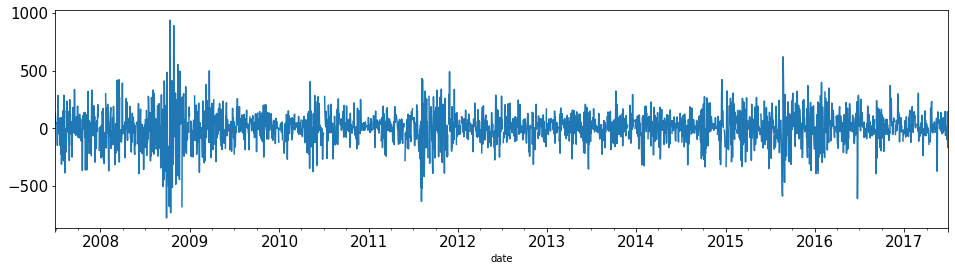

In [ ]:
sp500["diff_lag"].plot(figsize=(16, 4));

Since this operation is so common, Pandas has the diff function that computes the differences based on the period:

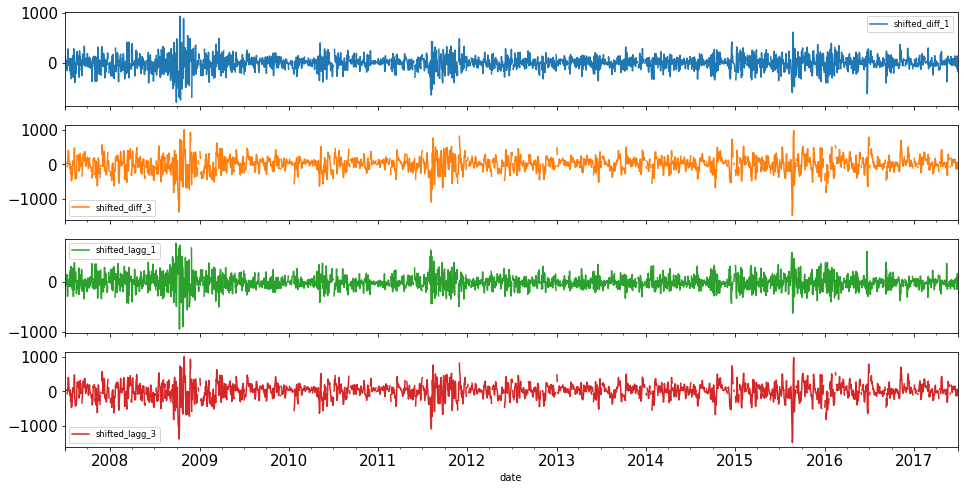

In [ ]:
sp500.drop(["lagged_1", "diff_lag"], axis=1, inplace=True)

sp500["shifted_diff_1"] = sp500["djia"].diff(periods=1)
sp500["shifted_diff_3"] = sp500["djia"].diff(periods=3)
sp500["shifted_lagg_1"] = sp500["djia"].diff(periods=-1)
sp500["shifted_lagg_3"] = sp500["djia"].diff(periods=3)

sp500.drop("djia", axis=1).plot(figsize=(16, 8), subplots=True);

### 3.2 Percentage changes 


Another common metric that can be derived from time-series data is day-to-day percentage change:

In [ ]:
sp500.drop(
    ["shifted_diff_1", "shifted_diff_3", "shifted_lagg_1", "shifted_lagg_3"],
    axis=1,
    inplace=True,
)

In [ ]:
sp500["shifted"] = sp500["djia"].shift(1)
sp500["change"] = sp500["djia"].div(sp500["shifted"]).sub(1).mul(100)

sp500.head()

,djia,shifted,change
date,,,
2007-06-29,13408.62,NaN,NaN
2007-07-02,13535.43,13408.62,0.945735
2007-07-03,13577.30,13535.43,0.309336
2007-07-04,NaN,13577.30,NaN
2007-07-05,13565.84,NaN,NaN


To calculate day-to-day percentage change, shift one period forward and divide the original distribution by the shifted one and subtract 1. The resulting values are given as proportions of what they were the day before.

Since it is a common operation, Pandas implements it with the pct_change function:

In [ ]:
sp500["pct_change"] = sp500["djia"].pct_change().mul(100)

sp500.head()

,djia,shifted,change,pct_change
date,,,,
2007-06-29,13408.62,NaN,NaN,NaN
2007-07-02,13535.43,13408.62,0.945735,0.945735
2007-07-03,13577.30,13535.43,0.309336,0.309336
2007-07-04,NaN,13577.30,NaN,0.000000
2007-07-05,13565.84,NaN,NaN,-0.084406


In [ ]:
sp500.drop(["shifted", "change", "pct_change"], axis=1, inplace=True)

## 4. Resampling 


Often, you may want to increase or decrease the granularity of time series to generate new insights. These operations are called resampling or changing the frequency of time series, and we will discuss the Pandas functions related to them in this section.

### 4.1 Changing the frequency with asfreq 

The SP500 stocks data does not have a fixed date frequency, i.e., the period difference between each date is not the same:

In [ ]:
sp500.head()

,djia
date,
2007-06-29,13408.62
2007-07-02,13535.43
2007-07-03,13577.30
2007-07-04,NaN
2007-07-05,13565.84


Let's fix this by giving it a calendar day frequency (daily):

In [ ]:
sp500.asfreq("D").head(7)

,djia
date,
2007-06-29,13408.62
2007-06-30,NaN
2007-07-01,NaN
2007-07-02,13535.43
2007-07-03,13577.30
2007-07-04,NaN
2007-07-05,13565.84


We just made the frequency of the date in SP500 more granular. As a result, new dates were added, leading to more missing values. You can now interpolate them using any of the techniques we discussed earlier.

You can see the list of built-in frequency aliases from here. A more interesting scenario would be using custom frequencies:

In [ ]:
# 5-hour frequency
sp500.asfreq("5h").head(7)  # This makes the dataset very large

,djia
date,
2007-06-29 00:00:00,13408.62
2007-06-29 05:00:00,NaN
2007-06-29 10:00:00,NaN
2007-06-29 15:00:00,NaN
2007-06-29 20:00:00,NaN
2007-06-30 01:00:00,NaN
2007-06-30 06:00:00,NaN


In [ ]:
# 10 day frequency
sp500.asfreq("10d", method="ffill").head(7)  # This makes the dataset smaller

,djia
date,
2007-06-29,13408.62
2007-07-09,13649.97
2007-07-19,14000.41
2007-07-29,13265.47
2007-08-08,13657.86
2007-08-18,13079.08
2007-08-28,13041.85


In [ ]:
# 10 month frequency
sp500.asfreq("10M", method="bfill").head(7)

,djia
date,
2007-06-30,13535.43
2008-04-30,12820.13
2009-02-28,6763.29
2009-12-31,10428.05
2010-10-31,11124.62
2011-08-31,11613.53
2012-06-30,12871.39


There is also a reindex function that operates similarly and supports additional missing value filling logic. We won't discuss it here as there are better options we will consider.

### 4.2 Downsampling with resample and aggregating 


In time series lingo, making the frequency of a DateTime less granular is called downsampling. The examples are changing the frequency from hourly to daily, from daily to weekly, etc.

We saw how to downsample with asfreq. A more powerful alternative is resample which behaves like pd.groupby. Just like groupby groups the data based on categorical values, resample groups the data by date frequencies.

Let's downsample the Apple/Google stock prices by month-end frequency:

In [ ]:
aapl_googl.resample("M")

Unlike asfreq, using resample only returns the data in the resampled state. To see each group, we need to use some type of function, similar to how we use groupby.

Since downsampling decreases the number of data points, we need an aggregation function like mean, median, or mode:

In [ ]:
aapl_googl.resample("M").mean().tail()

,AAPL,MSFT
date,,
2016-08-31,107.665217,57.717391
2016-09-30,110.857143,57.289524
2016-10-31,115.707143,58.397619
2016-11-30,110.154286,59.925238
2016-12-31,114.335714,62.118095


There are also functions that return the first or last record of a group:

In [ ]:
# Resample with business-month frequency
# and return the first record of each group
aapl_googl.resample("BM").first().tail()

,AAPL,MSFT
date,,
2016-08-31,106.05,56.58
2016-09-30,106.73,57.59
2016-10-31,112.52,57.42
2016-11-30,111.49,59.80
2016-12-30,109.49,59.20


In [ ]:
# Opposite of first()
aapl_googl.resample("Y").last().tail()  # Year-end frequency

,AAPL,MSFT
date,,
2012-12-31,76.02,26.71
2013-12-31,80.15,37.41
2014-12-31,110.38,46.45
2015-12-31,105.26,55.48
2016-12-31,115.82,62.14


It is also possible to use multiple aggregating functions using agg:

In [ ]:
aapl_googl.resample("Y").agg(["mean", "median", "std"]).head()

AAPL                         MSFT                  
                 mean  median       std       mean  median       std
date                                                                
2007-12-31  18.324821  17.700  5.035048  30.446813  29.930  2.319012
2008-12-31  20.282688  21.200  4.818750  26.647510  27.620  3.846213
2009-12-31  20.972976  20.340  5.687502  22.976786  23.395  4.246812
2010-12-31  37.134183  36.750  5.371650  27.050000  26.810  2.232324
2011-12-31  52.000357  51.005  3.703047  26.051508  25.900  1.179428

### 4.3 Upsampling with resample and interpolating 


The opposite of downsampling is making the DateTime more granular. This is called upsampling and includes operations like changing the frequency from daily to hourly, hourly to seconds, etc.

When upsampling, you introduce new dates leading to more missing values. This means you need to use some type of imputation:

In [ ]:
# Resample with business day freq and forward-fill
aapl_googl.resample("B").ffill().tail()

,AAPL,MSFT
date,,
2016-12-26,116.52,63.24
2016-12-27,117.26,63.28
2016-12-28,116.76,62.99
2016-12-29,116.73,62.90
2016-12-30,115.82,62.14


In [ ]:
# Resample with 20-hour frequency and back-fill
aapl_googl.resample("20h").bfill().sample(5)

,AAPL,MSFT
date,,
2012-09-26 08:00:00,97.33,30.16
2012-04-28 12:00:00,83.43,32.02
2013-09-17 04:00:00,66.38,33.32
2014-02-28 08:00:00,75.39,37.78
2014-02-04 04:00:00,73.23,35.82


### 4.4 Plotting the resampled data 


Resampling isn't going to give much if you don't plot its results.

In most cases, you will see new trends and patterns when you downsample. This is because downsampling reduces the granularity, thus eliminating noise:

In [ ]:
quarter_google = aapl_googl.resample("Q")["MSFT"].mean()
yearly_google = aapl_googl.resample("Y")["MSFT"].mean()

quarter_apple = aapl_googl.resample("Q")["AAPL"].mean()
yearly_apple = aapl_googl.resample("Y")["AAPL"].mean()

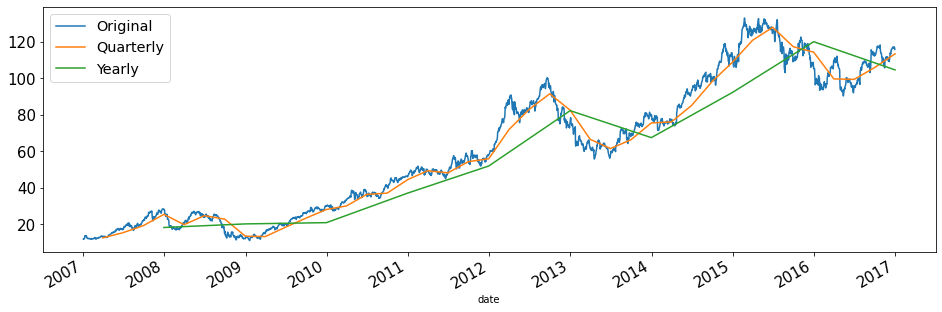

In [ ]:
# Plot Apple's downsampled stocks
aapl_googl["AAPL"].plot(figsize=(16, 5), label="Original")
quarter_apple.plot(label="Quarterly")
yearly_apple.plot(label="Yearly")
plt.legend(fontsize="x-large");

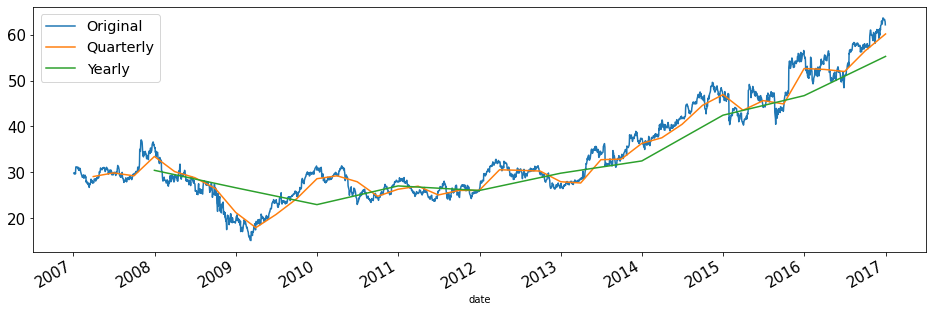

In [ ]:
# Plot Google's downsampled stocks
aapl_googl["MSFT"].plot(figsize=(16, 5), label="Original")
quarter_google.plot(label="Quarterly")
yearly_google.plot(label="Yearly")
plt.legend(fontsize="x-large");

Plotting the upsampled distribution is only going to introduce more noise, so we won't do it here.

## 5. Comparing the growth of multiple time series 


It is common to compare two or more numeric values that change over time. For example, we might want to see the growth rate of Google and Apple's stock prices. But here is the problem:

In [ ]:
aapl_googl.mean()

AAPL    61.537545
MSFT    33.995677
dtype: float64

Google's stock prices are way higher than Apple's. Plotting the stocks together would probably squish Apple's to a flat line. In other words, the two stocks have different scales.

To fix this, statisticians use normalization. The most common variation is choosing the first recorded value and dividing the rest of the samples by that amount. This shows how each record changes compared to the first.

Here is an example:

In [ ]:
aapl_googl.dropna(inplace=True)

# The first rows will contain ones because
# they are being divided by themselvs
aapl_googl.div(aapl_googl.iloc[0]).head(10)

,AAPL,MSFT
date,,
2007-01-03,1.000000,1.000000
2007-01-04,1.022556,0.998326
2007-01-05,1.015038,0.992632
2007-01-08,1.020050,1.002344
2007-01-09,1.104428,1.003349
2007-01-10,1.157895,0.993302
2007-01-11,1.143693,1.028131
2007-01-12,1.129490,1.045211
2007-01-16,1.158730,1.043537


The above output shows that for the first 3 dates, Apple stocks didn't change. Then, it increased by 1% of what it was on the first date ('2010–12–16'). Google's prices are more volatile, fluctuating between 1 and 2% increases during the first 10 dates.

Now, let's plot them to compare growth:

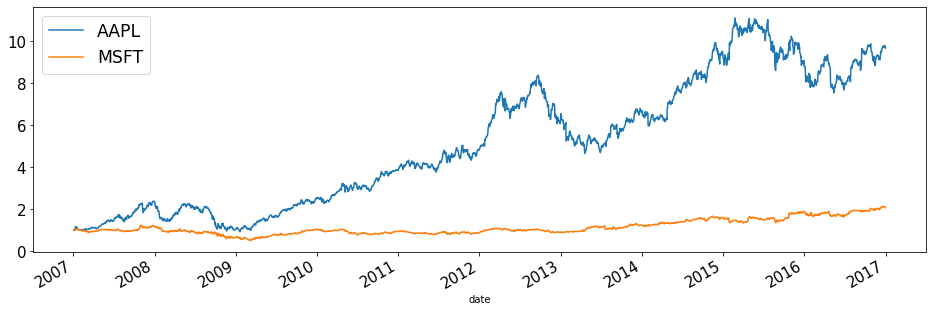

In [ ]:
# Normalize
normalized_aapl_goog = aapl_googl.div(aapl_googl.iloc[0])

normalized_aapl_goog.plot(figsize=(16, 5))
plt.legend(fontsize="xx-large");

Both Apple's and Google's achieved over 300% growth from 2011 to 2017. This plot may be even more interesting if we compare their growth to other 500 Fortune Companies:

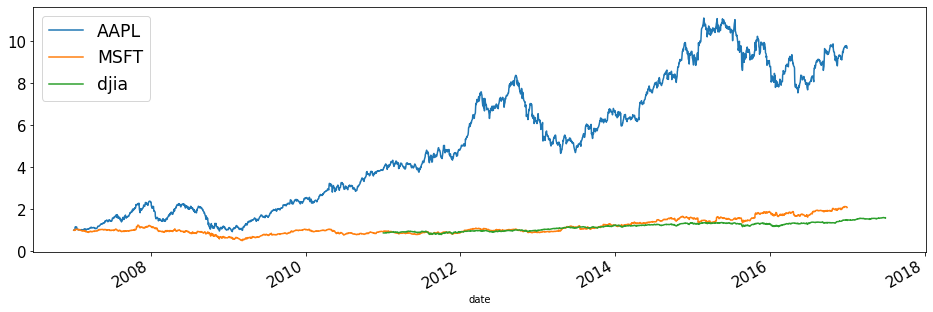

In [ ]:
# Normalize SP500 dataset
normalized_sp500 = sp500.div(sp500.iloc[0])

# PLot
fig, ax = plt.subplots(figsize=(16, 5))

normalized_aapl_goog.plot(ax=ax)
normalized_sp500["2011":].plot(label="S&P500", ax=ax)

plt.legend(fontsize="xx-large");


As you can see, Apple and Google have much higher growth than other top 500 companies in the US.

## 6. Window functions 


There is another type of function that helps you analyze time-series data in novel ways. These are called window functions, and they help you aggregate over a custom number of rows called 'windows.'

For example, I can create a 30-day window over my Medium subscribers data to see the total number of subscribers for the past 30 days on any given day. Or a restaurant owner might create a weekly window to see average sales of the past week. Examples are endless as you can create a window of any size over your data.

Let's explore these in more detail.

### 6.1 Rolling window functions 


Rolling window functions will have the same length. As they slide through the data, their coverage (number of rows don't change). Here is an example window of 5 periods sliding through the data:

![WindowFunction](Obr1.png)

Here is how we create rolling windows in pandas:

In [ ]:
aapl_googl.rolling(window=5)

Rolling [window=5,center=False,axis=0,method=single]

Just like resample, it is in a read-only state - to use each window, we should chain some type of function. For example, let's create a cumulative sum for every past 5 periods:

In [ ]:
aapl_googl["GOOG_5d_roll"] = aapl_googl["MSFT"].rolling(window=5).sum()

aapl_googl.head(10)

,AAPL,MSFT,GOOG_5d_roll
date,,,
2007-01-03,11.97,29.86,NaN
2007-01-04,12.24,29.81,NaN
2007-01-05,12.15,29.64,NaN
2007-01-08,12.21,29.93,NaN
2007-01-09,13.22,29.96,149.20
2007-01-10,13.86,29.66,149.00
2007-01-11,13.69,30.70,149.89
2007-01-12,13.52,31.21,151.46
2007-01-16,13.87,31.16,152.69


Obviously, the first 4 rows will be NaNs. Any other row will contain the sum of the previous 4 rows and the current one.

Pay attention to the window argument. If you pass an integer, the window size will be determined by that number of rows. If you pass a frequency alias such as months, years, 5 hours, or 7 weeks, the window size will be whatever number of rows that includes the single unit of the passed frequency. In other words, a 5-period window might have a different size than a 5-day frequency window.

As an example, let's plot 90 and 360-day moving averages for Google stock prices and plot them:

In [ ]:
aapl_googl["90D_roll_mean"] = aapl_googl["MSFT"].rolling(window="90D").mean()
aapl_googl["360D_roll_mean"] = aapl_googl["MSFT"].rolling(window="360D").mean()

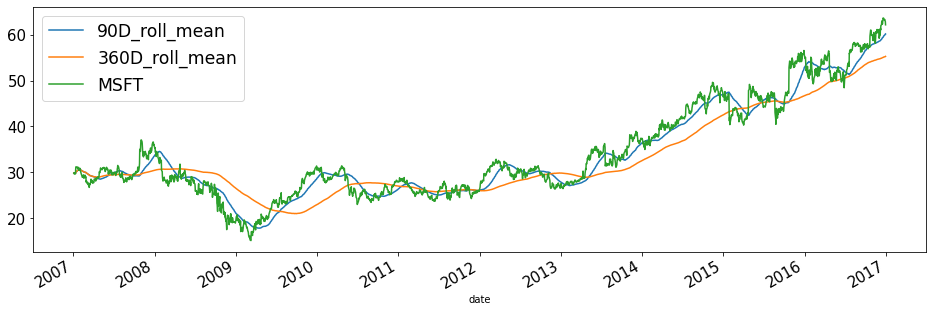

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))

aapl_googl[["90D_roll_mean", "360D_roll_mean", "MSFT"]].plot(ax=ax)

plt.legend(fontsize="xx-large");

Just like groupby and resample, you can calculate multiple metrics with the agg function for each window.

### 6.2 Expanding window functions 


Another type of window function deals with expanding windows. Each new window will contain all the records up to the current date:

![WindowFunctionDiffType](Obr2.png)

Expanding windows are useful for calculating 'running' metrics-for example, running sum, mean, min and max, running rate of return, etc.

Below, you will see how to calculate the cumulative sum. The cumulative sum is actually an expanding window function with a window size of 1:

In [ ]:
aapl_googl.drop(
    ["GOOG_5d_roll", "90D_roll_mean", "360D_roll_mean"], axis=1, inplace=True
)

In [ ]:
aapl_googl["expanding_cumsum"] = aapl_googl["MSFT"].expanding(min_periods=1).sum()
# The same operation with cumsum() func
aapl_googl["cumsum_function"] = aapl_googl["MSFT"].cumsum()

aapl_googl.head()

,AAPL,MSFT,expanding_cumsum,cumsum_function
date,,,,
2007-01-03,11.97,29.86,29.86,29.86
2007-01-04,12.24,29.81,59.67,59.67
2007-01-05,12.15,29.64,89.31,89.31
2007-01-08,12.21,29.93,119.24,119.24
2007-01-09,13.22,29.96,149.20,149.20


expanding function has a min_periods parameter that determines the initial window size.

Now, let's plot the running min and max of S&P500 stocks:

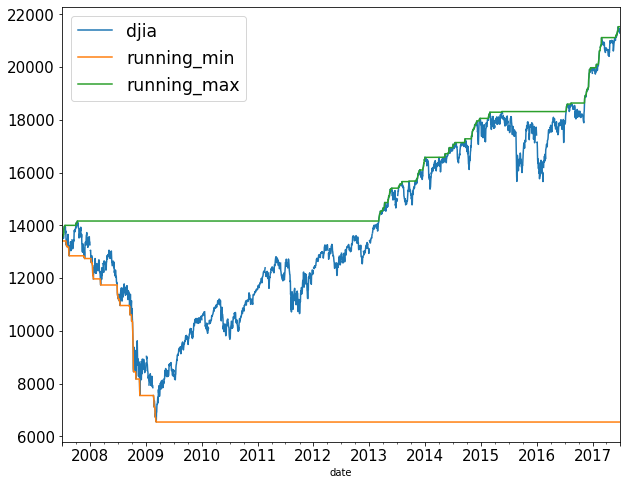

In [ ]:
sp500["running_min"] = sp500["djia"].expanding().min()  # same as cummin()
sp500["running_max"] = sp500["djia"].expanding().max()

fig, ax = plt.subplots(figsize=(10, 8))

sp500.plot(ax=ax)
plt.legend(fontsize="xx-large");

## Summary 


I think congratulations are in order!

Now, you know every single Pandas function you can use to manipulate time-series data. It has been an excruciatingly long post, but it was definitely worth it since now, you can tackle any time series data thrown at you.

This post was mainly focused on data manipulation. The next posts in the series will be about more in-depth time series analyses, similar posts on every single plot you can create on time series, and dedicated articles on forecasting. Stay tuned!